<a href="https://colab.research.google.com/github/yamaguchinorimitsu/ajax_app/blob/master/%E3%82%B9%E3%83%83%E3%82%AD%E3%83%AA%E6%A9%9F%E6%A2%B0%E7%AC%AC11%E7%AB%A0%E7%B7%B4%E7%BF%92%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv('/content/Bank.csv')
print(df.shape)
df.head()

(27128, 16)


,id,age,job,marital,education,default,amount,housing,loan,contact,day,month,duration,campaign,previous,y
0,1,39,blue-collar,married,secondary,no,1756.0,yes,no,cellular,3,apr,370.055237,1,0,1
1,2,51,entrepreneur,married,primary,no,1443.0,no,no,cellular,18,feb,233.998933,10,0,1
2,3,36,management,single,tertiary,no,436.0,no,no,cellular,13,apr,NaN,1,2,0
3,4,63,retired,married,secondary,no,474.0,no,no,cellular,25,jan,252.525808,1,0,0
4,5,31,management,single,tertiary,no,354.0,no,no,cellular,30,apr,NaN,1,2,0


In [3]:
# まず、ダミー変数化をしたいが、文字列の列が複数あるので抜き出す。
str_col_name=['job','default','marital','education','housing','loan','contact','month']
str_df = df[str_col_name]
#複数列を一気にダミー変数化
str_df2=pd.get_dummies(str_df,drop_first=True)

num_df = df.drop(str_col_name,axis=1)#数値列を抜き出す
df2 = pd.concat([num_df,str_df2,str_df],axis=1)#結合(今後の集計の利便性も考慮してstr_dfも結合しておく)

In [4]:
#訓練&検証データとテストデータに分割
train_val,test = train_test_split(df2,test_size=0.1,random_state=9)
train_val.head()

,id,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,job,default,marital,education,housing,loan,contact,month
13378,13379,46,0.0,10,378.293875,1,0,1,0,0,...,0,0,unemployed,no,married,tertiary,yes,no,cellular,jul
3800,3801,41,-333.0,30,300.845752,3,2,0,1,0,...,0,0,blue-collar,no,divorced,secondary,yes,no,cellular,jan
10398,10399,30,5389.0,6,159.053623,3,0,1,0,0,...,0,0,management,no,single,tertiary,no,no,cellular,aug
23401,23402,39,255.0,5,334.802583,1,0,0,0,0,...,0,0,management,no,single,tertiary,yes,no,sending _document,may
26223,26224,47,33.0,5,NaN,1,0,1,0,0,...,0,0,services,no,single,secondary,yes,no,cellular,may


In [5]:
#特徴量の当たりがついた
#しかし、そもそもこの線形回帰は外れ値の影響を強く受けるので調べる。
from sklearn.covariance import MinCovDet
num_df=train_val.drop(str_col_name,axis=1)
num_df=num_df.drop('id',axis=1)
num_df2=num_df.dropna()
mcd2 =MinCovDet(random_state=0,support_fraction=0.7)
mcd2.fit(num_df2)

MinCovDet(random_state=0, support_fraction=0.7)

<Axes: >

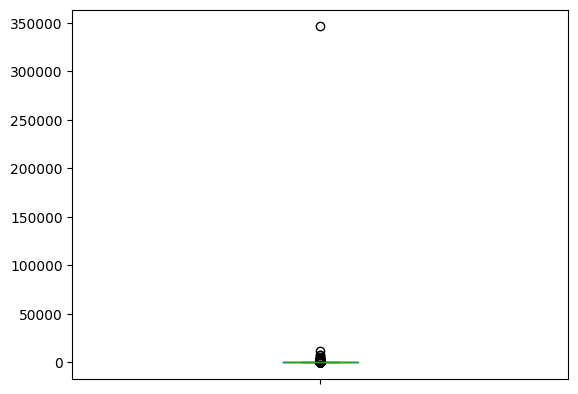

In [6]:
dis =mcd2.mahalanobis(num_df2)
dis=pd.Series(dis)
dis.plot(kind="box")


In [7]:
no=dis[dis>300000].index
#先頭から2561番目が外れ値となる事が分かったので９章の付録で紹介したilocを利用する
no=num_df2.iloc[no[0]:(no[0]+1),:].index
train_val2 = train_val.drop(no)

In [9]:
#欠損行を削除
not_nan_df = train_val2.dropna()
temp_t =not_nan_df[['duration']]
temp_x = not_nan_df.drop(str_col_name,axis=1)

#durationとyに関係があるという仮定が成り立つならば、適切な推定をするためには,
temp_x = temp_x.drop(['y','duration','id'],axis=1)
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso,Ridge

a,b,c,d= train_test_split(temp_x,temp_t,random_state=0,test_size=0.2)
maxvalue=0
v=0
#今回はLasso回帰を利用するので、特徴量選択はしない
for i in range(1,42):
    val = i/20
    model_liner = Lasso(random_state=0,alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner.fit(a,c)
    if maxvalue < model_liner.score(b,d):
        v=val
        maxvalue = model_liner.score(b,d)
print(v,maxvalue)

0.15 0.7304944115519963


In [10]:
model_liner = Lasso(random_state=0,alpha=v)
#今回は予測させたいだけなので、標準化はしない
model_liner.fit(a,c)
#pd.Series(model_liner)

Lasso(alpha=0.15, random_state=0)

In [11]:
# 考え方をここで変える。durationとyに関係が強いという仮定が正しいならば、durationを推定するのに
#yを利用するのは合理的ではなかろうか？ただテストデータでは、yの値が本当に未知という状況で検証するので
#テストデータでもdurationが欠損している場合は上記model_linerを利用する。
#欠損行を削除
not_nan_df = train_val2.dropna()
temp_t =not_nan_df[['duration']]
temp_x = not_nan_df.drop(str_col_name,axis=1)
#yを消さない
temp_x = temp_x.drop(['duration','id'],axis=1)
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso,Ridge

a,b,c,d= train_test_split(temp_x,temp_t,random_state=0,test_size=0.2)
maxvalue=0
v=0
for i in range(1,42):
    val = i/20
    model_liner2 = Lasso(random_state=0,alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner2.fit(a,c)
    if maxvalue < model_liner2.score(b,d):
        v=val
        maxvalue = model_liner2.score(b,d)
print(v,maxvalue)

0.1 0.8192780104182655


In [12]:
#結果
pd.Series(model_liner2.coef_,index=temp_x.columns)

age                            3.685596
amount                        -0.000010
day                           -0.000000
campaign                      -0.000000
previous                       2.951859
y                             41.674580
job_blue-collar                0.000000
job_entrepreneur              -0.000000
job_housemaid                 -0.000000
job_management                -0.000000
job_retired                   -0.000000
job_self-employed              0.000000
job_services                   0.000000
job_student                   -0.000000
job_technician                 0.000000
job_unemployed                -0.000000
job_unknown                   -0.000000
default_yes                    0.000000
marital_married                0.000000
marital_single                -0.000000
education_secondary            0.000000
education_tertiary            -0.000000
education_unknown             -0.000000
housing_yes                  127.082018
loan_yes                      82.595567


In [13]:
train_val3 = train_val.copy()
is_null=train_val3['duration'].isnull()
#temp_x = tain_val3.drop(str_col_name,axis=1)
#修正
temp_x = train_val3.drop(str_col_name,axis=1)

temp_x = temp_x.drop(['duration','id'],axis=1)
temp_x = temp_x[is_null]
#non_x=train_val2.loc[is_null,['housing_yes','loan_yes','age','marital_single','job_student']]
pred_d = model_liner2.predict(temp_x)
train_val3.loc[is_null,'duration']=pred_d

(24415, 48)

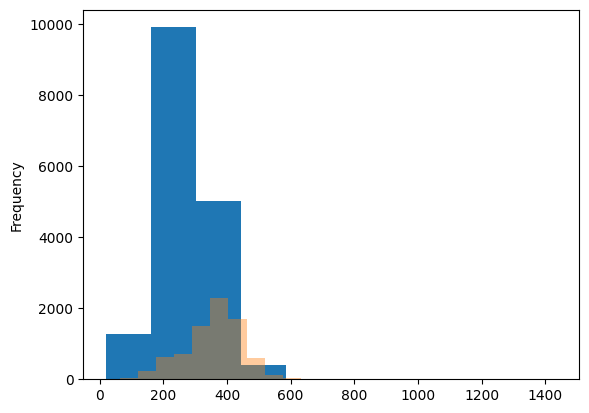

In [16]:
#ヒストグラムの確認
train_val3.loc[train_val3['y']==0,"duration"].plot(kind="hist")
train_val3.loc[train_val3['y']==1,"duration"].plot(kind="hist",alpha=0.4)

#y=1の方が、durationが大きい傾向がやっぱりありそう
train_val3.shape

In [17]:
train_val3["duration"].describe()

count    24415.000000
mean       297.012163
std         92.504680
min         19.038719
25%        227.001265
50%        292.726974
75%        362.290315
max       1435.488040
Name: duration, dtype: float64

In [18]:
#まず、さくっと学習できるようなlearn関数を定義する。
def learn(x,t,i):
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

    datas=[x_train,x_val,y_train,y_val]
    #不均衡データに対応できるように、class_weight引数も設定
    model = tree.DecisionTreeClassifier(random_state=i,max_depth=i,class_weight='balanced')
    model.fit(x_train,y_train)
    train_score=model.score(x_train,y_train)
    
    
    val_score=model.score(x_val,y_val)
    return train_score,val_score,model,datas

t =train_val3['y']
x = train_val3.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
#とりあえず、for文で様々な木の深さでの正解率を調べてみる
for i in range(1,15):
    s1,s2,model,datas = learn(x,t,i)
    print(i,s1,s2)

1 0.754351832889617 0.7565021503174278
2 0.754351832889617 0.7565021503174278
3 0.7117038705713701 0.708171206225681
4 0.7706328077001843 0.7765717796436616
5 0.7595740323571575 0.7513823469178783
6 0.7923919721482695 0.7855826336268688
7 0.8189637517919311 0.8046283022731927
8 0.8383166086422281 0.8220356338316609
9 0.8561847225066558 0.8193733360638952
10 0.8741040344050789 0.821421257423715
11 0.8882346917878353 0.8179397911120213
12 0.9068195781281999 0.8185541675199672
13 0.9212062256809338 0.810976858488634
14 0.9369752201515462 0.8130247798484538
